# S001 King Keltner

King Keltner 策略是基于移动平均线创立的, 基本思想是 在由最高价, 最低价, 收盘价得出的中心价格基础上计算出市场价格通道线的上下轨, 当价格上穿上轨时做多, 下穿下轨时做空, 由于不是每一次突破都会成功, 因此, 合理的止损设置显得尤为重要, 在kk策略中, 选择中心价格作为出场信号

1. 计算中心价 MP = 最高价, 最低价, 收盘价三者平均后的40周期移动平均价

MP = MA((high+low+close)/3, 40)


2. 计算真实价格区间 TrueRange

TR =  max( abs(high_t - low_t), abs(high_t- close_t-1), abs(low_t - close_t-1))

3. 计算通道上下轨 (upBand, dnBand), 其中mu是一个可变参数, 默认为1

upBand = MP + mu*MA(TR, 40)

dnBand = MP - mu*MA(TR, 40)

4. 计算平仓价格

FP = MP = MA((high+low+close)/3, 40)

5. 开平仓条件

买入开仓 BUY_OPEN : 当前周期MP > 上一个周期的MP  AND 当前价格 > upBand

卖出开仓 SELL_OPEN:  当前周期MP < 上一个周期的MP  AND 当前价格 < dnBand

平仓 : 当前周期价格 下穿  平仓价格FP

平仓 : 当前周期价格 上穿  平仓价格FP

平仓既是止盈 也是止损条件


策略简单描述到此, 下面进入分析和策略代码部分

In [1]:
import QUANTAXIS as QA

no display found. Using non-interactive Agg backend
if you use ssh, you can use ssh with -X parmas to avoid this issue


In [2]:
N = 40
mu = 1

In [3]:
import pandas as pd
def strategy001(data, N=40, mu=1):
    MP = QA.MA((data.high+data.low+data.close)/3, N)
    TR = pd.concat([abs(data.high - data.low), abs(data.high- data.close.shift(1)), abs(data.low - data.close.shift(1))],axis=1).max(axis=1)
    upBand = MP + mu*QA.MA(TR, N)
    dnBand = MP - mu*QA.MA(TR, N)
    FP = MP
    return pd.DataFrame({'MP': MP, 'TR': TR, 'upBand': upBand, 'dnBand':dnBand, 'FP':MP})

## 灌入数据

In [4]:
data = QA.QA_fetch_future_day_adv("RBL8", '2018-05-01', '2019-09-10')

In [5]:
data

< QA_DataStruct_Future_day with 1 securities >

In [6]:
ind = data.add_func(strategy001)

In [7]:
print(ind.tail())

                          MP     TR       upBand       dnBand           FP
date       code                                                           
2019-09-04 RBL8  3721.116667   63.0  3801.866667  3640.366667  3721.116667
2019-09-05 RBL8  3706.566667   56.0  3787.516667  3625.616667  3706.566667
2019-09-06 RBL8  3691.416667   64.0  3772.166667  3610.666667  3691.416667
2019-09-09 RBL8  3678.450000  115.0  3760.275000  3596.625000  3678.450000
2019-09-10 RBL8  3664.558333   44.0  3745.008333  3584.108333  3664.558333


## 实现策略

In [8]:
MPDIFF = ind.MP.diff().dropna()

In [9]:
# 在测试阶段, 我们只需要写个伪回测代码即可

In [10]:

lastprice = 0

for idx, item in data.iterrows():
    try:
        if MPDIFF.loc[idx]>0 and item['close']> ind.upBand.loc[idx]:
            print('buyOPEN _ {}'.format(idx))
        if MPDIFF.loc[idx]<0 and item['close']< ind.dnBand.loc[idx]:
            print('sellOPEN_ {}'.format(idx))
        if lastprice< ind.FP.loc[idx] and item['close']> ind.FP.loc[idx]:
            print('close')
        if lastprice> ind.FP.loc[idx] and item['close']< ind.FP.loc[idx]:
            print('close')
    except:
        pass
    lastprice = item['close']

close
buyOPEN _ (Timestamp('2018-06-29 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-04 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-05 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-09 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-10 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-11 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-12 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-13 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-16 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-17 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-18 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-19 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-20 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-23 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-24 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-25 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-26 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-27 00:00:00'), 'RBL8')
buyOPEN _ (Timestamp('2018-07-30 00:00:0

## 回测代码

In [11]:
user = QA.QA_User(username='quantaxiss', password='quantaxis')
portfolio = user.new_portfolio('strategy101')

In [12]:
acc = portfolio.new_account(account_cookie='acc001', init_hold={'RBL8':0}, init_cash=30000, market_type=QA.MARKET_TYPE.FUTURE_CN)
lastprice = 0

for idx, item in data.iterrows():
    try:
        if acc.hold_available.get(idx[1],0) ==0 and MPDIFF.loc[idx]>0 and item['close']> ind.upBand.loc[idx]:
            print('buyOPEN _ {}'.format(idx))
            acc.receive_simpledeal(
                code= idx[1],
                trade_price = item['close'],
                trade_amount = 1,
                trade_towards= QA.ORDER_DIRECTION.BUY_OPEN,
                trade_time= idx[0])
        if acc.hold_available.get(idx[1],0) ==0 and MPDIFF.loc[idx]<0 and item['close']< ind.dnBand.loc[idx]:
            print('sellOPEN_ {}'.format(idx))
            acc.receive_simpledeal(
                code= idx[1],
                trade_price = item['close'],
                trade_amount = 1,
                trade_towards= QA.ORDER_DIRECTION.SELL_OPEN,
                trade_time= idx[0])
        if lastprice< ind.FP.loc[idx] and item['close']> ind.FP.loc[idx]:
            print('close')
            if acc.hold_available.get(idx[1],0)>0:
                #多单止盈
                acc.receive_simpledeal(
                    code= idx[1],
                    trade_price = item['close'],
                    trade_amount = 1,
                    trade_towards= QA.ORDER_DIRECTION.SELL_CLOSE,
                    trade_time= idx[0])
            elif acc.hold_available.get(idx[1],0)<0:
                # 空单止损
                acc.receive_simpledeal(
                    code= idx[1],
                    trade_price = item['close'],
                    trade_amount = 1,
                    trade_towards= QA.ORDER_DIRECTION.BUY_CLOSE,
                    trade_time= idx[0])
                
        if lastprice> ind.FP.loc[idx] and item['close']< ind.FP.loc[idx]:
            print('close')
            if acc.hold_available.get(idx[1],0)>0:
                #多单止损
                acc.receive_simpledeal(
                    code= idx[1],
                    trade_price = item['close'],
                    trade_amount = 1,
                    trade_towards= QA.ORDER_DIRECTION.SELL_CLOSE,
                    trade_time= idx[0])
            elif acc.hold_available.get(idx[1],0)<0:
                # 空单止盈
                acc.receive_simpledeal(
                    code= idx[1],
                    trade_price = item['close'],
                    trade_amount = 1,
                    trade_towards= QA.ORDER_DIRECTION.BUY_CLOSE,
                    trade_time= idx[0])
    except:
        pass
    lastprice = item['close']

QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
close
buyOPEN _ (Timestamp('2018-06-29 00:00:00'), 'RBL8')
close
close
buyOPEN _ (Timestamp('2018-09-10 00:00:00'), 'RBL8')
close
sellOPEN_ (Timestamp('2018-09-25 00:00:00'), 'RBL8')
close
close
close
close
sellOPEN_ (Timestamp('2018-11-06 00:00:00'), 'RBL8')
close
close
buyOPEN _ (Timestamp('2019-01-23 00:00:00'), 'RBL8')
close
close
sellOPEN_ (Timestamp('2019-04-01 00:00:00'), 'RBL8')
close
sellOPEN_ (Timestamp('2019-04-02 00:00:00'), 'RBL8')
close
buyOPEN _ (Timestamp('2019-04-11 00:00:00'), 'RBL8')
close
close
close
close
close
close
close
sellOPEN_ (Timestamp('2019-05-14 00:00:00'), 'RBL8')
close
buyOPEN _ (Timestamp('2019-05-21 00:00:00'), 'RBL8')
close
close
close
sellOPEN_ (Timestamp('2019-06-17 00:00:00'), 'RBL8')
close
close
buyOPEN _ (Timestamp('2019-06-21 00:00:00'), 'RBL8')
close
close
sellOPEN_ (Timestamp('2019-08-07 00:00:00'), 'RBL8')


In [13]:
acc.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen,direction,total_frozen
0,2018-06-29 00:00:00,RBL8,3807.0,1,26569.893,None,None,None,acc001,3.807,0,None,3426.3,2,3426.3
1,2018-08-30 00:00:00,RBL8,4118.0,-1,33102.075,None,None,None,acc001,4.118,0,None,0.0,-3,0.0
2,2018-09-10 00:00:00,RBL8,4284.0,1,29242.191,None,None,None,acc001,4.284,0,None,3855.6,2,3855.6
3,2018-09-11 00:00:00,RBL8,4071.0,-1,30963.720,None,None,None,acc001,4.071,0,None,0.0,-3,0.0
4,2018-09-25 00:00:00,RBL8,4060.0,-1,27305.660,None,None,None,acc001,4.060,0,None,3654.0,-2,3654.0
5,2018-10-17 00:00:00,RBL8,4197.0,1,29585.463,None,None,None,acc001,4.197,0,None,0.0,3,0.0
6,2018-11-06 00:00:00,RBL8,3962.0,-1,26015.701,None,None,None,acc001,3.962,0,None,3565.8,-2,3565.8
7,2019-01-08 00:00:00,RBL8,3505.0,1,34147.996,None,None,None,acc001,3.505,0,None,0.0,3,0.0
8,2019-01-23 00:00:00,RBL8,3644.0,1,30864.752,None,None,None,acc001,3.644,0,None,3279.6,2,3279.6
9,2019-03-25 00:00:00,RBL8,3692.0,-1,34620.660,None,None,None,acc001,3.692,0,None,0.0,-3,0.0


In [14]:
performance = QA.QA_Performance(acc)

In [15]:
performance.pnl_fifo

,sell_date,buy_date,amount,sell_price,buy_price,rawdirection,unit,pnl_ratio,pnl_money,hold_gap,if_buyopen,openprice,opendate,closeprice,closedate
code,,,,,,,,,,,,,,,
RBL8,2018-08-30,2018-06-29,1,4118.0,3807.0,buy,10,0.081692,3110.0,62 days,True,3807.0,2018-06-29 00:00:00,4118.0,2018-08-30 00:00:00
RBL8,2018-09-11,2018-09-10,1,4071.0,4284.0,buy,10,-0.049720,-2130.0,1 days,True,4284.0,2018-09-10 00:00:00,4071.0,2018-09-11 00:00:00
RBL8,2018-09-25,2018-10-17,1,4060.0,4197.0,sell,10,-0.032642,-1370.0,22 days,False,4060.0,2018-09-25 00:00:00,4197.0,2018-10-17 00:00:00
RBL8,2018-11-06,2019-01-08,1,3962.0,3505.0,sell,10,0.130385,4570.0,63 days,False,3962.0,2018-11-06 00:00:00,3505.0,2019-01-08 00:00:00
RBL8,2019-03-25,2019-01-23,1,3692.0,3644.0,buy,10,0.013172,480.0,61 days,True,3644.0,2019-01-23 00:00:00,3692.0,2019-03-25 00:00:00
RBL8,2019-04-01,2019-04-01,1,3497.0,3497.0,sell,10,0.000000,0.0,0 days,False,3497.0,2019-04-01 00:00:00,3497.0,2019-04-01 00:00:00
RBL8,2019-04-02,2019-04-08,1,3560.0,3730.0,sell,10,-0.045576,-1700.0,6 days,False,3560.0,2019-04-02 00:00:00,3730.0,2019-04-08 00:00:00
RBL8,2019-04-18,2019-04-11,1,3710.0,3808.0,buy,10,-0.025735,-980.0,7 days,True,3808.0,2019-04-11 00:00:00,3710.0,2019-04-18 00:00:00
RBL8,2019-05-14,2019-05-16,1,3663.0,3742.0,sell,10,-0.021112,-790.0,2 days,False,3663.0,2019-05-14 00:00:00,3742.0,2019-05-16 00:00:00


In [16]:
acc.market_type

'future_cn'

In [17]:
risk = QA.QA_Risk(acc)

margin!


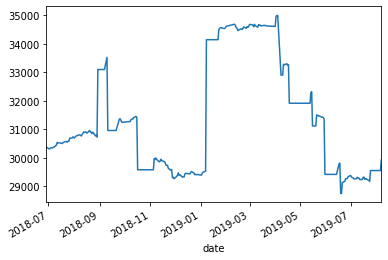

In [18]:
# 用市价计算的每日总资产
(risk.daily_market_value+ acc.daily_cash.cash).plot()

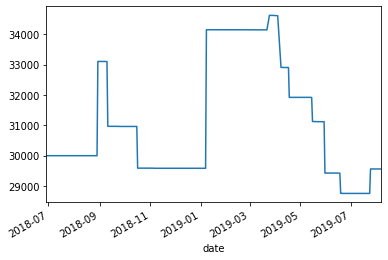

In [19]:
# 用冻结保证金计算的总资产

(acc.daily_frozen+ acc.daily_cash.cash).plot()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

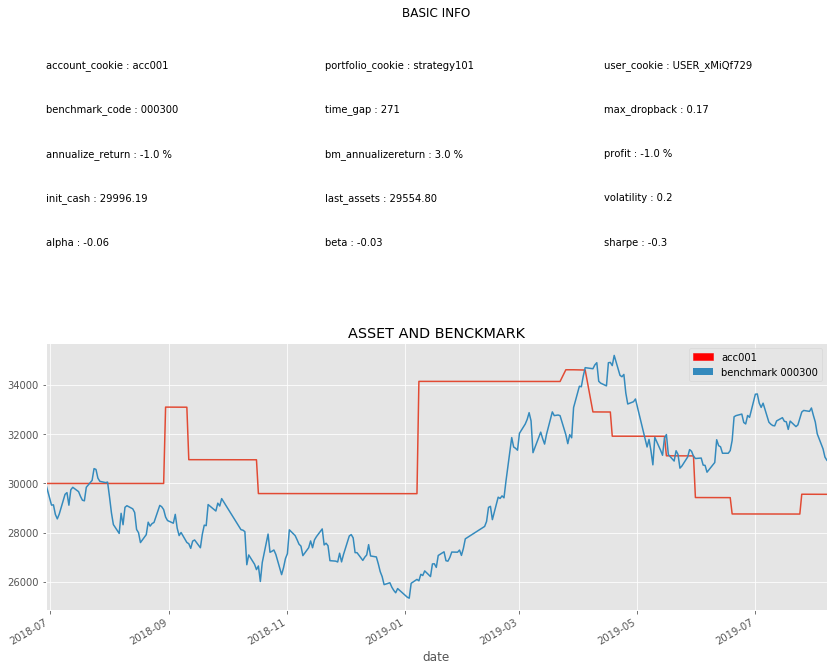

In [20]:

risk.plot_assets_curve()


In [21]:
risk.save()
acc.save()